# Assignment 2  for Advanced ML Class - Reinforcement Learning with MiniPacman Environment

## Nazih Kalo | Winter 2020

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import random
import time
import os
import gc

from keras.models import Sequential, clone_model
from keras.layers import Dense, Flatten, Conv2D, InputLayer
from keras.callbacks import CSVLogger, TensorBoard
from keras.optimizers import Adam
import keras.backend as K

import gym

plt.rcParams['figure.figsize'] = (9, 9)

Using TensorFlow backend.
/Users/nazihkalo/anaconda3/envs/tf1.0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nazihkalo/anaconda3/envs/tf1.0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nazihkalo/anaconda3/envs/tf1.0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nazi

In [4]:
cd iLykei_ReinforcedLearningMaterials

/Users/nazihkalo/Desktop/UChicago_Analytics/Quarter 4/Advanced ML/Lecture 4/iLykei_ReinforcedLearningMaterials


In [5]:
import json
from mini_pacman import PacmanGame

with open('test_params.json', 'r') as file:
    read_params = json.load(file)
game_params = read_params['params']
env = PacmanGame(**game_params)

In [6]:
from mini_pacman import test, random_strategy, naive_strategy

test(strategy=random_strategy, log_file='test_pacman_log.json')

Your average score is 35.032, median is 5.0, saved log to 'test_pacman_log.json'. Do not forget to upload it for submission!


5.0

In [7]:
def create_dqn_model(input_shape, nb_actions, dense_layers, dense_units):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for i in range(dense_layers):
        model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return model

Create a network using specific input shape and action space size. We call this network *online*.

In [9]:
obs = env.reset()

In [41]:
input_shape = (len(list(obs['player']) + list(sum(obs['monsters'], ())) + list(sum(obs['diamonds'], ())) + list(sum(obs['walls'], ()))),)
nb_actions = 9
dense_layers = 5
dense_units = 256

online_network = create_dqn_model(input_shape, nb_actions, dense_layers, dense_units)
online_network.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 2313      
Total params: 273,929
Trainable params: 273,929
Non-trainable params: 0
________________________________________________

#### Uncomment below for testing the rendering

In [49]:
# obs = env.reset()
# done = False
# total_scores = []
# ep_reward = []
# episode_history = []

# for i in range(100):
#     obs = env.reset()
#     rewards = 0
#     while not obs['end_game']:
#         action = random.randrange(1,10)  # select random action
        
#         obs = env.make_action(action)     # make action and get results
#         episode_history.append(obs)
#         reward = obs['reward']
#         rewards += reward
#         total_scores.append(obs['total_score'])
#     ep_reward.append(rewards)
        
#         env.render()
#         time.sleep(0.01)
    
# env.close()
# print('Score =', score)

Score = 24


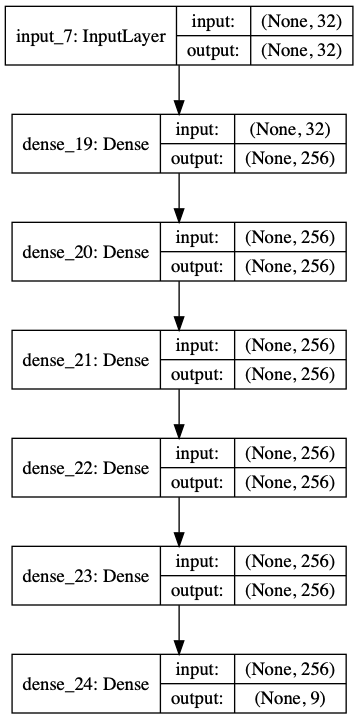

In [99]:
from keras.utils import plot_model
plot_model(online_network, to_file='online_DenseNetwork.png',show_shapes=True,show_layer_names=True)

This network is used to explore states and rewards of Markov decision process according to an $\varepsilon$-greedy exploration strategy:

In [130]:
def epsilon_greedy(q_values, epsilon, n_outputs):
    if random.random() < epsilon:
        return random.randrange(1,n_outputs)  # random action
    else:
        return np.argmax(q_values)+1          # q-optimal action

Online network stores explored information in a *replay memory*, a double-ended queue (deque).

In [56]:
from collections import deque

replay_memory_maxlen = 1000000
replay_memory = deque([], maxlen=replay_memory_maxlen)

So, online network explores the game using $\varepsilon$-greedy strategy and saves experienced transitions in replay memory. 

In order to produce Q-values for $\varepsilon$-greedy strategy, following the proposal of the [original paper by Google DeepMind](https://www.nature.com/articles/nature14236), use another network, called *target network*, to calculate "ground-truth" target for the online network. *Target network*, has the same architecture as online network and is not going to be trained. Instead, weights from the online network are periodically copied to target network.

In [57]:
target_network = clone_model(online_network)
target_network.set_weights(online_network.get_weights())

In [58]:
def get_observation(obs):
    return np.array([list(obs['player']) + list(sum(obs['monsters'], ())) + list(sum(obs['diamonds'], ())) + list(sum(obs['walls'], ()))])

## Training DQN

First, define hyperparameters (Do not forget to change them before moving to cluster):

In [135]:
name = 'MsPacman_DQN'  # used in naming files (weights, logs, etc)
n_steps = 10000        # total number of training steps (= n_epochs)
warmup = 1000          # start training after warmup iterations
training_interval = 4  # period (in actions) between training steps
save_steps = int(n_steps/10)  # period (in training steps) between storing weights to file
copy_steps = 100       # period (in training steps) between updating target_network weights
gamma = 0.9            # discount rate
skip_start = 90        # skip the start of every game (it's just freezing time before game starts)
batch_size = 64        # size of minibatch that is taken randomly from replay memory every training step
double_dqn = False     # whether to use Double-DQN approach or simple DQN (see above)
# eps-greedy parameters: we slowly decrease epsilon from eps_max to eps_min in eps_decay_steps
eps_max = 1.0
eps_min = 0.05
eps_decay_steps = int(n_steps/2)

learning_rate = 0.001

### Compile online-network with Adam optimizer, mean squared error loss and `mean_q` metric, which measures the maximum of predicted q-values averaged over samples from minibatch (we expect it to increase during training process).

In [136]:
def mean_q(y_true, y_pred):
    return K.mean(K.max(y_pred, axis=-1))

online_network.compile(optimizer=Adam(learning_rate), loss='mse', metrics=[mean_q])

### Create folder for logs and trained weights:

In [137]:
if not os.path.exists(name):
    os.makedirs(name)
    
weights_folder = os.path.join(name, 'weights')
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)

### Use standard callbacks:

In [138]:
csv_logger = CSVLogger(os.path.join(name, 'log.csv'), append=True, separator=';')
tensorboard = TensorBoard(log_dir=os.path.join(name, 'tensorboard'), write_graph=False, write_images=False)

### Next chunk of code explores the game, trains online network and periodically copies weights to target network.

In [139]:
# counters:
step = 0          # training step counter (= epoch counter)
iteration = 0     # frames counter
episodes = 0      # game episodes counter
done = True       # indicator that env needs to be reset
nb_actions = 10

episode_scores = []  # collect total scores in this list and log it later

env = PacmanGame(**game_params)

obs = env.reset()
while step < n_steps:
    if obs['end_game']:  # game over, restart it
        obs = env.reset()
        score = 0  # reset score for current episode
    
    state = get_observation(obs)

    # Online network evaluates what to do
    iteration += 1
    
    q_values = online_network.predict(state)[0]  # calculate q-values using online network
    # select epsilon (which linearly decreases over training steps):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    #nb_actions = obs['possible_actions']
    action = epsilon_greedy(q_values, epsilon, nb_actions)
    # Play:
    obs = env.make_action(action) # make action and get results
    reward = obs['reward']
    score += reward
    
    if obs['end_game']:
        episode_scores.append(obs['total_score'])
    
    done = obs['end_game']
    next_state = get_observation(obs)
    # Let's memorize what just happened
    replay_memory.append((state, action, reward, next_state, done))

    if iteration >= warmup and iteration % training_interval == 0:
        # learning branch
        step += 1
        minibatch = random.sample(replay_memory, batch_size)
        replay_state = np.array([x[0][0] for x in minibatch])
        replay_action = np.array([x[1] for x in minibatch])
        replay_rewards = np.array([x[2] for x in minibatch])
        replay_next_state = np.array([x[3][0] for x in minibatch])
        replay_done = np.array([x[4] for x in minibatch], dtype=int)

        # calculate targets (see above for details)
        if double_dqn == False:
            # DQN
            target_for_action = replay_rewards + (1-replay_done) * gamma * \
                                    np.amax(target_network.predict(replay_next_state), axis=1)
        else:
            # Double DQN
            best_actions = np.argmax(online_network.predict(replay_next_state), axis=1)
            target_for_action = replay_rewards + (1-replay_done) * gamma * \
                                    target_network.predict(replay_next_state)[np.arange(batch_size), best_actions]

        target = online_network.predict(replay_state)  # targets coincide with predictions ...
        target[np.arange(batch_size), replay_action-1] = target_for_action  #...except for targets with actions from replay
        
        # Train online network
        online_network.fit(replay_state, target, epochs=step, verbose=1, initial_epoch=step-1,
                           callbacks=[csv_logger, tensorboard])

        # Periodically copy online network weights to target network
        if step % copy_steps == 0:
            target_network.set_weights(online_network.get_weights())
        # And save weights
        if step % save_steps == 0:
            online_network.save_weights(os.path.join(weights_folder, 'weights_{}.h5f'.format(step)))
            gc.collect()  # also clean the garbage

Epoch 1/1
64/64 [==============================] - 0s 3ms/step - loss: 49.5349 - mean_q: 42.2111
Epoch 2/2
64/64 [==============================] - 0s 109us/step - loss: 32.2192 - mean_q: 52.1325
Epoch 3/3
64/64 [==============================] - 0s 105us/step - loss: 52.9499 - mean_q: 42.1101
Epoch 4/4
64/64 [==============================] - 0s 112us/step - loss: 55.6536 - mean_q: 45.3410
Epoch 5/5
64/64 [==============================] - 0s 113us/step - loss: 67.0516 - mean_q: 43.1240
Epoch 6/6
64/64 [==============================] - 0s 112us/step - loss: 84.8178 - mean_q: 50.7433
Epoch 7/7
64/64 [==============================] - 0s 119us/step - loss: 23.4601 - mean_q: 45.8676
Epoch 8/8
64/64 [==============================] - 0s 116us/step - loss: 49.6997 - mean_q: 53.8497
Epoch 9/9
64/64 [==============================] - 0s 105us/step - loss: 38.1241 - mean_q: 54.8903
Epoch 10/10
64/64 [==============================] - 0s 111us/step - loss: 35.9256 - mean_q: 54.1247
Epoch 11/1

## Defining custom strategy function to satisfy requirements of the test function in mini_pacman.py

In [160]:
def custom_strategy(obs):
    state = get_observation(obs)
    q_values = online_network.predict(state)[0]
    return np.argmax(q_values)+1

## Viewing the results of 1.6M Step training of the network architecture described above

In [165]:
import json
with open('/Users/nazihkalo/Documents/GitHub/Q_Learning_mountain_car/test_pacman_log.json', 'r') as file:
    test_log = json.load(file)

In [184]:
scores = []
for a in range(len(test_log)):
    scores.append([i['total_score'] for i in test_log[a]])

Text(0.5, 0, 'Step')

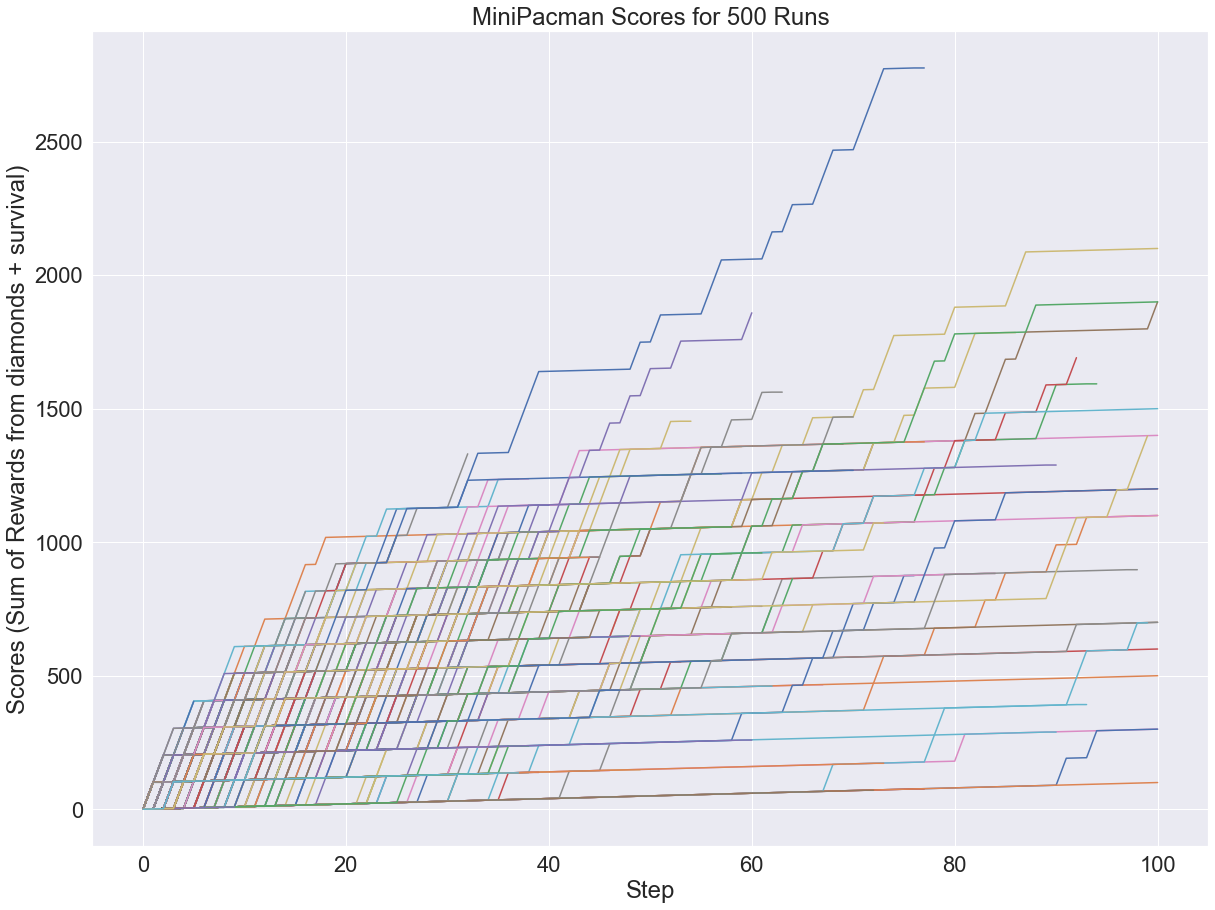

In [198]:
plt.figure(figsize = (20,15))
sns.set(font_scale=2)
import seaborn as sns
for i in range(len(scores)):
    sns.lineplot(x = range(len(scores[i])), y = scores[i])

plt.title('MiniPacman Scores for 500 Runs')
plt.ylabel('Scores (Sum of Rewards from diamonds + survival)')
plt.xlabel('Step')

In [196]:
##Flattened Scores
# [i['total_score'] for log in test_log for i in log]